In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import cv2 as cv
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

2024-11-17 21:48:05.717437: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1731876485.737457    7213 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1731876485.744297    7213 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-17 21:48:05.768006: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
images_csv = pd.read_csv('data.csv')

In [3]:
images_csv = images_csv[['path', 'label']]
images_csv.head()

,path,label
0,Surprise/1bd930d6a1c717c11be33db74823f661cb53f...,Surprise
1,Surprise/cropped_emotions.100096~12fffff.png,Surprise
2,Surprise/0df0e470e33093f5b72a8197fa209d684032c...,Surprise
3,Surprise/cropped_emotions.260779~12fffff.png,Surprise
4,Surprise/cropped_emotions.263616~12fffff.png,Surprise


In [4]:
emotions = images_csv['label'].unique()
emotions_dic = {}
for index, emotion in enumerate(emotions):
    emotions_dic[emotion] = index

print(emotions_dic)

{'Surprise': 0, 'Sad': 1, 'Ahegao': 2, 'Happy': 3, 'Neutral': 4, 'Angry': 5}


In [5]:
e_images = images_csv.replace(emotions_dic)

/tmp/ipykernel_7213/2357465474.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  e_images = images_csv.replace(emotions_dic)


In [6]:
Sizes = []
for i in e_images['path']:
    image = cv.imread(f'dataset/{i}')
    height = image.shape[0]
    width = image.shape[1]
    Sizes.append(height*width)

In [7]:
e_images.insert(2, 'Sizes', Sizes)

In [8]:
diffrence = 100000
photo_filter = (e_images['Sizes'] >= diffrence)
e_images_filtered = e_images.loc[photo_filter]
e_images_filtered

,path,label,Sizes
0,Surprise/1bd930d6a1c717c11be33db74823f661cb53f...,0,230400
4,Surprise/cropped_emotions.263616~12fffff.png,0,187833
7,Surprise/0a15c44d8be6cc71cd9d8ab595266e5147459...,0,459684
9,Surprise/cropped_emotions.263517~12fffff.png,0,166160
10,Surprise/cropped_emotions.265653~12fffff.png,0,128310
...,...,...,...
15439,Angry/cropped_emotions.571531~angry.png,5,412125
15440,Angry/cropped_emotions.157999~angry.png,5,106110
15441,Angry/cropped_emotions.231380~angry.png,5,194530
15442,Angry/cropped_emotions.232172~angry.png,5,350620


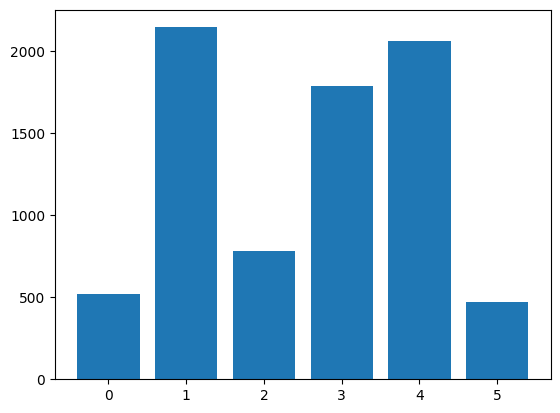

In [9]:
photos_by_emotions = e_images_filtered.groupby('label').count()
plt.bar(photos_by_emotions.index, photos_by_emotions['path']);

In [10]:
X = e_images_filtered['path']
y = e_images_filtered['label']

In [11]:
X_images = []
for i in X:
    image = cv.imread(f'dataset/{i}')
    rgb_image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    resize_image = cv.resize(rgb_image, (100, 100))
    std_image = resize_image / 255
    X_images.append(std_image)

X_images_np = np.array(X_images).astype(dtype='float32')
y_np = y.to_numpy().astype(dtype='long')

In [12]:
np.where(y_np == 3)[0][0]
Images = []
for image in range(6):
    index = np.where(y_np == image)[0][0]
    Images.append(X_images_np[index])

In [13]:
Images[0].shape

(100, 100)

/tmp/ipykernel_7213/3186762474.py:6: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


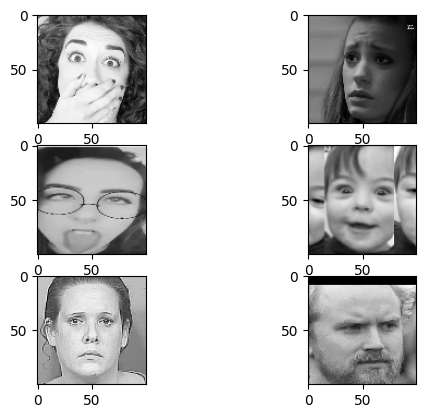

In [14]:
fig, axs = plt.subplots(3,2)

for index, ax in enumerate(axs.ravel()):
    ax.imshow(Images[index], cmap='gray')
    
fig.show()

In [15]:
X_images_np = np.array([X_images_np])
X_images_np = np.moveaxis(X_images_np, 0, 3)

In [16]:
X_images_np.shape

(7756, 100, 100, 1)

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X_images_np, y_np, test_size=0.3, random_state=123, stratify=y)

In [18]:
X_train.shape

(5429, 100, 100, 1)

In [19]:
y_train

array([0, 1, 4, ..., 1, 1, 1])

In [20]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten

In [69]:
model = Sequential()
model.add(Conv2D(5, (5, 5), activation = 'relu', input_shape=(100, 100, 1)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(5, (5, 5), activation = 'relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(50, activation = 'relu'))
model.add(Dense(6, activation = 'log_softmax'))

In [70]:
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 96, 96, 5)      │           130 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 48, 48, 5)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 44, 44, 5)      │           630 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 22, 22, 5)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 2420)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 50)             │       121,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 6)              │           306 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 122,116 (477.02 KB)

 Trainable params: 122,116 (477.02 KB)

 Non-trainable params: 0 (0.00 B)

In [71]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer = optimizer, loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

In [72]:
history = model.fit(X_train, y_train, epochs=20)

Epoch 1/20


2024-11-17 21:58:06.152179: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{} for conv (f32[32,5,44,44]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,5,48,48]{3,2,1,0}, f32[5,5,5,5]{3,2,1,0}, f32[5]{0}), window={size=5x5}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}


163/170 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.2955 - loss: 1.6188

2024-11-17 21:58:09.752460: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{} for conv (f32[21,5,44,44]{3,2,1,0}, u8[0]{0}) custom-call(f32[21,5,48,48]{3,2,1,0}, f32[5,5,5,5]{3,2,1,0}, f32[5]{0}), window={size=5x5}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}


170/170 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.2981 - loss: 1.6147
Epoch 2/20
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4800 - loss: 1.2905
Epoch 3/20
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5522 - loss: 1.1356
Epoch 4/20
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5901 - loss: 1.0308
Epoch 5/20
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6256 - loss: 0.9560
Epoch 6/20
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6430 - loss: 0.8972
Epoch 7/20
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6412 - loss: 0.8756
Epoch 8/20
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6855 - loss: 0.8052
Epoch 9/20
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7047 - loss: 0.7342
Epoch 10/20
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7150 - loss: 0.7077
Epoch 11/20
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7472 - loss: 0.6559
Epoch 12/20
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accurac

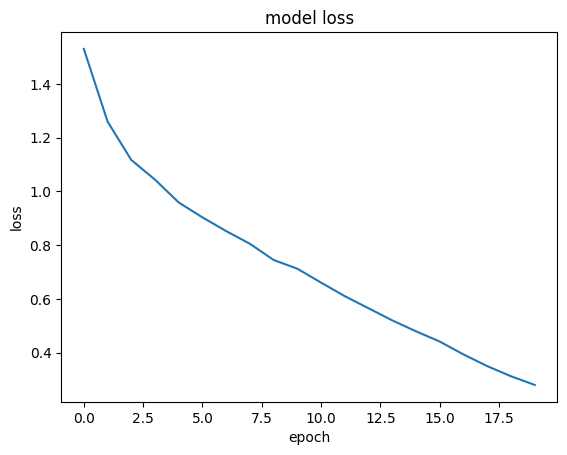

In [73]:
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

In [74]:
np.exp(model.predict(np.array([X_train[0]])))

2024-11-17 21:58:30.068328: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{} for conv (f32[1,5,44,44]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,5,48,48]{3,2,1,0}, f32[5,5,5,5]{3,2,1,0}, f32[5]{0}), window={size=5x5}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 478ms/step


2024-11-17 21:58:30.307606: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion', 36 bytes spill stores, 28 bytes spill loads



array([[8.3923864e-01, 6.6671230e-02, 4.7106710e-03, 1.2527064e-06,
        8.4041849e-02, 5.3363573e-03]], dtype=float32)

In [75]:
y_train[0]

np.int64(0)

In [76]:
model.evaluate(X_test, y_test)

2024-11-17 21:58:30.873665: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{} for conv (f32[32,5,44,44]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,5,48,48]{3,2,1,0}, f32[5,5,5,5]{3,2,1,0}, f32[5]{0}), window={size=5x5}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}


62/73 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5991 - loss: 1.4746

2024-11-17 21:58:31.666138: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{} for conv (f32[23,5,44,44]{3,2,1,0}, u8[0]{0}) custom-call(f32[23,5,48,48]{3,2,1,0}, f32[5,5,5,5]{3,2,1,0}, f32[5]{0}), window={size=5x5}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}


73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.5969 - loss: 1.4827


[1.5341670513153076, 0.5853029489517212]